In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 
matplotlib.rcParams["figure.figsize"] = (20,10)

In [97]:
#Data Load: Load King County home prices into a dataframe
df1 = pd.read_csv("kc_house_data.csv")
df1.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [98]:
df1.shape

(21613, 21)

In [99]:
##examine the zipcode feature
df1.groupby('zipcode')['zipcode'].agg('count')

zipcode
98001    362
98002    199
98003    280
98004    317
98005    168
        ... 
98177    255
98178    262
98188    136
98198    280
98199    317
Name: zipcode, Length: 70, dtype: int64

In [100]:
#df1['total_sqft'] = df1['sqft_living']+df1['sqft_lot']+df1['sqft_basement']+df1['sqft_above']
#df1.head()

In [101]:
##drop features that are not required to build our model
df2 = df1.drop(['id','date','sqft_lot','floors','waterfront','sqft_above','sqft_basement','view','condition', \
                'grade','yr_built','yr_renovated','lat','long','sqft_living15','sqft_lot15'],axis='columns')
df2.head()

,price,bedrooms,bathrooms,sqft_living,zipcode
0,221900.0,3,1.00,1180,98178
1,538000.0,3,2.25,2570,98125
2,180000.0,2,1.00,770,98028
3,604000.0,4,3.00,1960,98136
4,510000.0,3,2.00,1680,98074


In [102]:
df2.bedrooms.unique()

array([ 3,  2,  4,  5,  1,  6,  7,  0,  8,  9, 11, 10, 33])

In [103]:
df2.bathrooms.unique()

array([1.  , 2.25, 3.  , 2.  , 4.5 , 1.5 , 2.5 , 1.75, 2.75, 3.25, 4.  ,
       3.5 , 0.75, 4.75, 5.  , 4.25, 3.75, 0.  , 1.25, 5.25, 6.  , 0.5 ,
       5.5 , 6.75, 5.75, 8.  , 7.5 , 7.75, 6.25, 6.5 ])

In [104]:
#Data Cleaning: Handle NA values

In [105]:
df2.isnull().sum()

price          0
bedrooms       0
bathrooms      0
sqft_living    0
zipcode        0
dtype: int64

In [106]:
df2[df2['bedrooms']>20]
### error (33 bedroom with 1620 sqft_living)

,price,bedrooms,bathrooms,sqft_living,zipcode
15870,640000.0,33,1.75,1620,98103


In [157]:
df2.sqft_living.unique()

array([1180, 2570,  770, ..., 3087, 3118, 1425])

In [158]:

## detect if a given value in sqft_living is float or not
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [159]:
df2[~df2['sqft_living'].apply(is_float)].head(10)
### ~:negation, return dataframe that is NOT a float


,price,bedrooms,bathrooms,sqft_living,zipcode


In [160]:
#change the type of zipcode column to string
df2['zipcode'] = df2['zipcode'].astype(str)

In [161]:
# Feature Engineering
## Add new feature called price per square feet
df3 = df2.copy()
df3['price_per_sqft'] = df3['price']/df3['sqft_living']
df3.head()

,price,bedrooms,bathrooms,sqft_living,zipcode,price_per_sqft
0,221900.0,3,1.00,1180,98178,188.050847
1,538000.0,3,2.25,2570,98125,209.338521
2,180000.0,2,1.00,770,98028,233.766234
3,604000.0,4,3.00,1960,98136,308.163265
4,510000.0,3,2.00,1680,98074,303.571429


In [162]:
len(df3.zipcode.unique())

70

In [163]:
# Outlier Detection and Removal
## suppose that 300 sqft per bedroom is a typical threshold, find properties where this threshold is NOT met:
df3[df3.sqft_living/df3.bedrooms<300].head()

,price,bedrooms,bathrooms,sqft_living,zipcode,price_per_sqft
97,199000.0,4,1.5,1160,98023,171.551724
200,210000.0,3,1.0,860,98056,244.186047
319,268750.0,4,1.0,800,98166,335.937500
345,165000.0,4,1.0,1000,98178,165.000000
346,239900.0,4,1.0,1000,98178,239.900000


In [164]:
df3.shape

(21613, 6)

In [165]:
## remove above data errors:
df4 = df3[~(df3.sqft_living/df3.bedrooms<300)]
df4.shape

(21402, 6)

In [166]:
## check outliers of price_per_sqft:
df4.price_per_sqft.describe()
### min and max are too low and too high, which are very unlikely. 

count    21402.000000
mean       263.828389
std        109.876201
min         87.588235
25%        182.076835
50%        244.444444
75%        317.930856
max        810.138889
Name: price_per_sqft, dtype: float64

In [167]:
##remove these extreme cases based on standard deviation. Assume our data set has a normal distribution, 
## then around 68% data points should lie between mean and 1 sd. 
## We are going to filter out anything which is beyong 1 sd:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('zipcode'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df5 = remove_pps_outliers(df4)
df5.shape

(16380, 6)

Text(0, 0.5, 'Count')

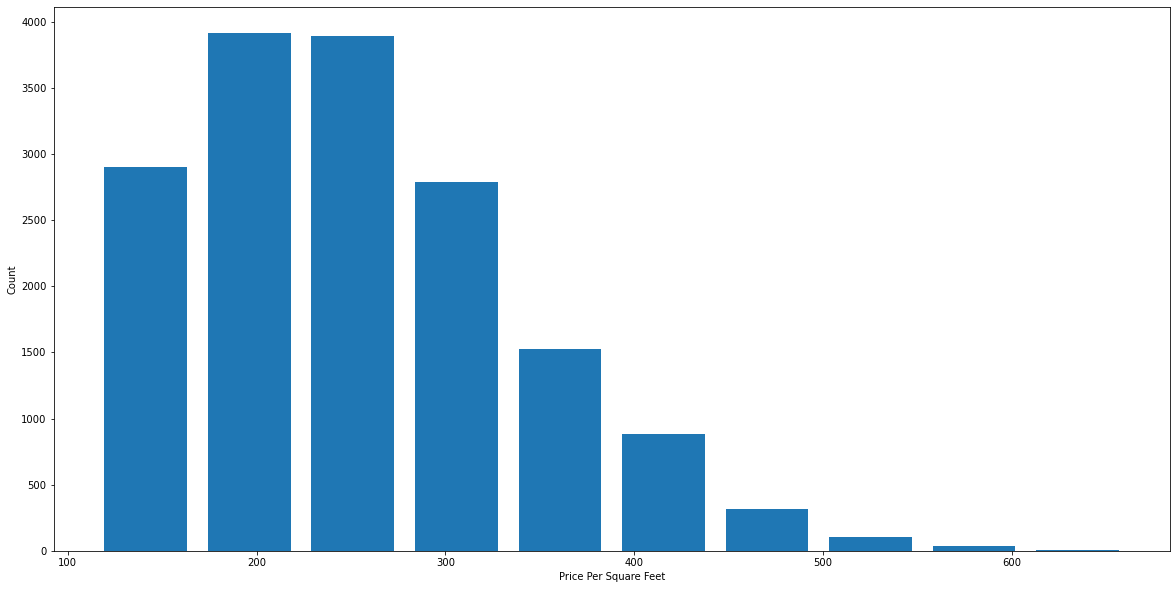

In [168]:
## plot a histogram to see how many apartments we have in per square feet area:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df5.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

### bell shape, normal distribution, looks good

In [169]:
##examine the bathroom feature:
df5.bathrooms.unique()

array([2.5 , 2.  , 1.5 , 1.75, 1.  , 2.75, 2.25, 3.  , 0.  , 0.75, 3.5 ,
       5.  , 3.25, 4.  , 3.75, 6.  , 5.5 , 4.25, 4.5 , 4.75, 5.25, 5.75,
       6.75, 0.5 , 1.25, 6.25])

Text(0, 0.5, 'Count')

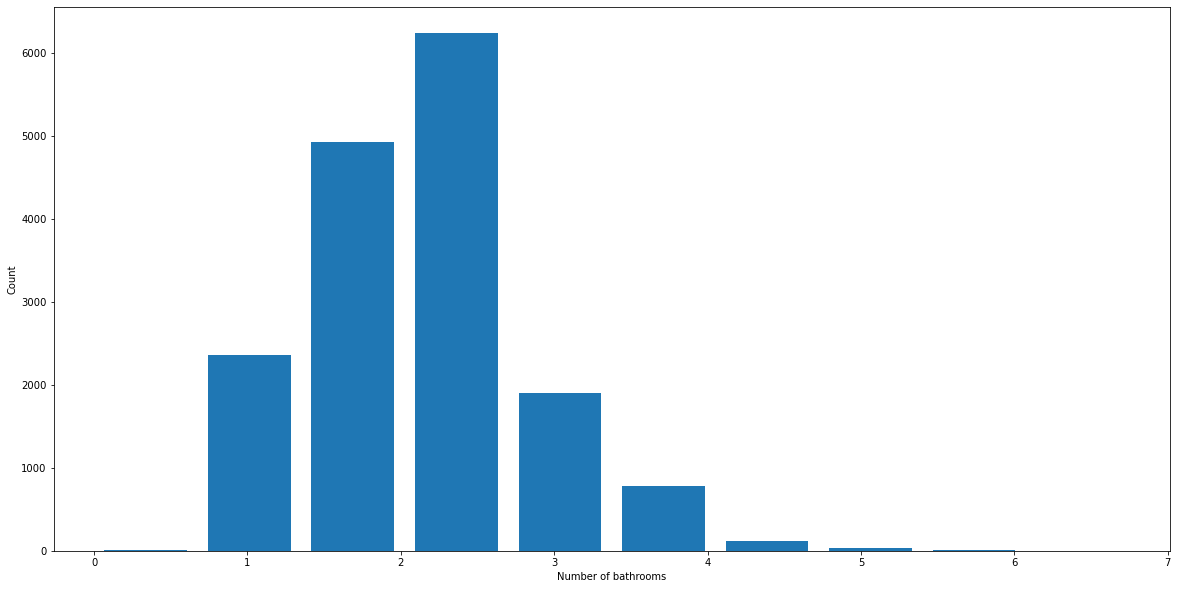

In [170]:
plt.hist(df5.bathrooms,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [171]:
##remove houses with zero bedroom or zero bathroom
df6 = df5[df5.bathrooms>0]
df6.shape

(16375, 6)

In [172]:
df7 = df6[df6.bedrooms>0]
df7.shape

(16372, 6)

In [173]:
## Suppose if the number of bathrooms is greater than the number of bedrooms+2, then we need to remove it as an outlier:
df7[df7.bathrooms>df7.bedrooms+2]

,price,bedrooms,bathrooms,sqft_living,zipcode,price_per_sqft


In [174]:
## drop unnecessary features to prepare for machine learning training
## drop pps since it is only used for prior outlier detection 
df8 = df7.drop(['price_per_sqft'],axis='columns')
df8.head()

,price,bedrooms,bathrooms,sqft_living,zipcode
0,287000.0,4,2.5,2240,98001
1,480000.0,4,2.5,3230,98001
2,465000.0,3,2.5,2714,98001
3,360000.0,4,2.5,2160,98001
4,230000.0,3,2.0,1450,98001


In [175]:
#rearrange the order of the columns
df8 = df8[['price','sqft_living','bedrooms','bathrooms','zipcode']]
df8.head()

,price,sqft_living,bedrooms,bathrooms,zipcode
0,287000.0,2240,4,2.5,98001
1,480000.0,3230,4,2.5,98001
2,465000.0,2714,3,2.5,98001
3,360000.0,2160,4,2.5,98001
4,230000.0,1450,3,2.0,98001


In [176]:
##Build a ML model and then use K Fold cross validation and GridSearchCV to come up with the best algorithm and the best parameters
### First convert categorical information (location) into numerical information
### use pandas dummies method:
dummies = pd.get_dummies(df8.zipcode)
dummies.head(3)

,98001,98002,98003,98004,98005,98006,98007,98008,98010,98011,...,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [177]:
### concatenate df8 and these dummies
df8 = pd.concat([df8,dummies],axis='columns')
df8.head()

,price,sqft_living,bedrooms,bathrooms,zipcode,98001,98002,98003,98004,98005,...,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
0,287000.0,2240,4,2.5,98001,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,480000.0,3230,4,2.5,98001,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,465000.0,2714,3,2.5,98001,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,360000.0,2160,4,2.5,98001,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,230000.0,1450,3,2.0,98001,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [178]:
df9 = df8.drop('zipcode',axis='columns')
df9.head()

,price,sqft_living,bedrooms,bathrooms,98001,98002,98003,98004,98005,98006,...,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
0,287000.0,2240,4,2.5,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,480000.0,3230,4,2.5,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,465000.0,2714,3,2.5,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,360000.0,2160,4,2.5,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,230000.0,1450,3,2.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [179]:
df9.shape

(16372, 74)

In [180]:
##drop dependent variable price from the dataframe
X = df9.drop('price',axis='columns')
X.head()

,sqft_living,bedrooms,bathrooms,98001,98002,98003,98004,98005,98006,98007,...,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
0,2240,4,2.5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3230,4,2.5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2714,3,2.5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2160,4,2.5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1450,3,2.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [181]:
y = df9.price
y.head()

0    287000.0
1    480000.0
2    465000.0
3    360000.0
4    230000.0
Name: price, dtype: float64

In [182]:
##want 20% of my samples to be test samples and use the remaining 80% for model training:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [183]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

### gives a pretty descent score

0.8783085804491657

In [184]:
#Use K Fold cross validation to measure accuracy of our LinearRegression model:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

### ShuffleSplit will randomize my samples so that each of the fold have equal distribution of my data samples
### for majority of the time, I'm getting scores more than 80%

array([0.87484735, 0.88601612, 0.8879074 , 0.8791513 , 0.87989211])

In [185]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

/Users/veronica/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 72309707347103.34, tolerance: 126108787537.53778
  positive)
/Users/veronica/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78019948322635.9, tolerance: 132258212997.17105
  positive)
/Users/veronica/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75442561551701.17, tolerance: 128698285341.44203
  positive)
/Users/veronica/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

,model,best_score,best_params
0,linear_regression,0.881563,{'normalize': False}
1,lasso,0.881571,"{'alpha': 2, 'selection': 'cyclic'}"
2,decision_tree,0.843506,"{'criterion': 'mse', 'splitter': 'random'}"


In [186]:
##Based on above results we can say that LinearRegression and Lasso give the same best score. Hence we will just go with the LinearRegression.

In [187]:
X.columns

Index(['sqft_living', 'bedrooms', 'bathrooms', '98001', '98002', '98003',
       '98004', '98005', '98006', '98007', '98008', '98010', '98011', '98014',
       '98019', '98022', '98023', '98024', '98027', '98028', '98029', '98030',
       '98031', '98032', '98033', '98034', '98038', '98039', '98040', '98042',
       '98045', '98052', '98053', '98055', '98056', '98058', '98059', '98065',
       '98070', '98072', '98074', '98075', '98077', '98092', '98102', '98103',
       '98105', '98106', '98107', '98108', '98109', '98112', '98115', '98116',
       '98117', '98118', '98119', '98122', '98125', '98126', '98133', '98136',
       '98144', '98146', '98148', '98155', '98166', '98168', '98177', '98178',
       '98188', '98198', '98199'],
      dtype='object')

In [188]:
np.where(X.columns=='98003')[0][0]

5

In [189]:
#Test the model for few properties:
def predict_price(zipcode,sqft_living,bedrooms,bathrooms):    
    loc_index = np.where(X.columns==zipcode)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft_living
    x[1] = bedrooms
    x[2] = bathrooms
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]

In [192]:
predict_price('98028',1000,2,1)

188870.279296875

In [193]:
#Export the tested model to a pickle file

In [194]:
import pickle
with open('King_County_home_prices_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)

In [195]:
#Export location and column information to a file that will be useful later on in our prediction application
### The way the columns are structured (X.columns) and their index into the list is important for making a prediction

In [196]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))